In [8]:
pip install numpy scikit-learn matplotlib && pip install mongoengine

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
from mongoengine import (connect, ConnectionFailure)
from dotenv import load_dotenv

load_dotenv()

# Conecta ao MongoDB
def connect_db():
    try:
        connect(
            db="vendas",
            host="localhost",
            port=27017,
                )

    except ConnectionFailure:
        raise ("Erro ao conectar ao banco de dados ",ConnectionFailure)


In [30]:
from mongoengine import Document, IntField, DictField, ObjectIdField


class VendaMensal(Document):
    id = ObjectIdField(primary_key=True)  # corresponde ao _id do MongoDB
    mes = IntField(required=True, min_value=1, max_value=12)
    ano = IntField(required=True)
    produtos = DictField(field=IntField(), required=True)

    meta = {"collection": "vendas"}



=== PREVISÃO PARA: CAMISAS ===
Usando histórico de 5 anos para sazonalidade


--- Calculando previsões sazonais ---

Jan/2026:
  Anos considerados: [2025, 2024, 2023, 2022, 2021]
  Valores: [265, 250, 235, 225, 210]
  Média: 237.00

Fev/2026:
  Anos considerados: [2025, 2024, 2023, 2022, 2021]
  Valores: [275, 260, 245, 235, 220]
  Média: 247.00

Mar/2026:
  Anos considerados: [2025, 2024, 2023, 2022, 2021]
  Valores: [260, 240, 230, 220, 205]
  Média: 231.00

Abr/2026:
  Anos considerados: [2025, 2024, 2023, 2022, 2021]
  Valores: [270, 255, 245, 230, 215]
  Média: 243.00

Mai/2026:
  Anos considerados: [2025, 2024, 2023, 2022, 2021]
  Valores: [280, 260, 255, 240, 225]
  Média: 252.00

Jun/2026:
  Anos considerados: [2025, 2024, 2023, 2022, 2021]
  Valores: [290, 270, 265, 250, 230]
  Média: 261.00
Previsão (com tendência) para Jan/2026: 277.50
Previsão (com tendência) para Fev/2026: 287.50
Previsão (com tendência) para Mar/2026: 270.00
Previsão (com tendência) para Abr/2026: 283.50

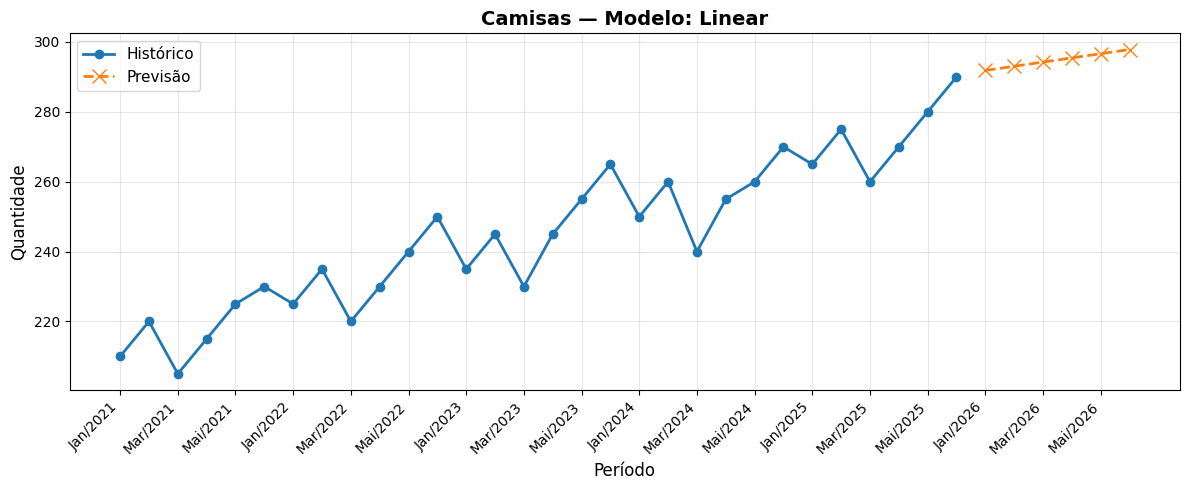

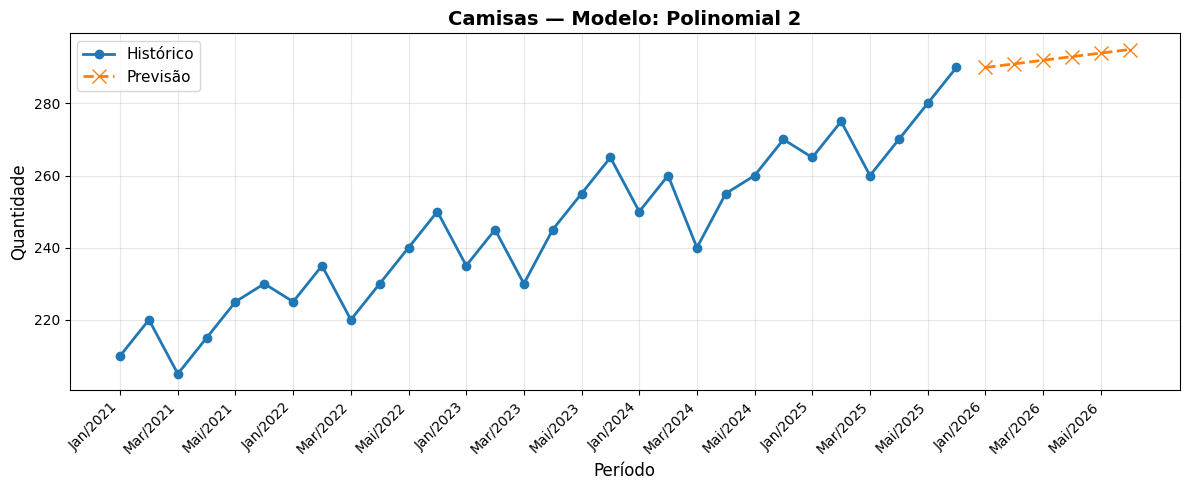

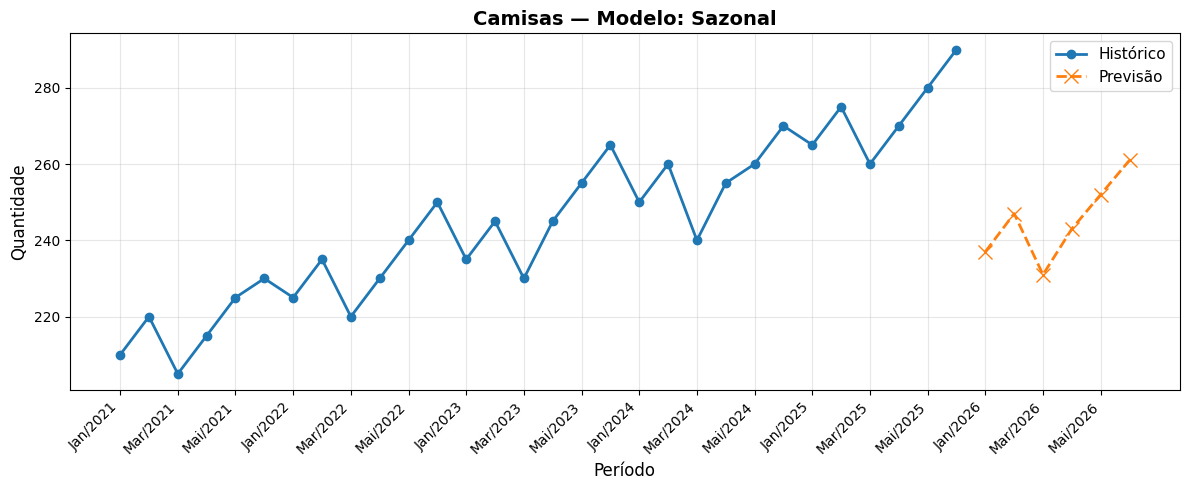

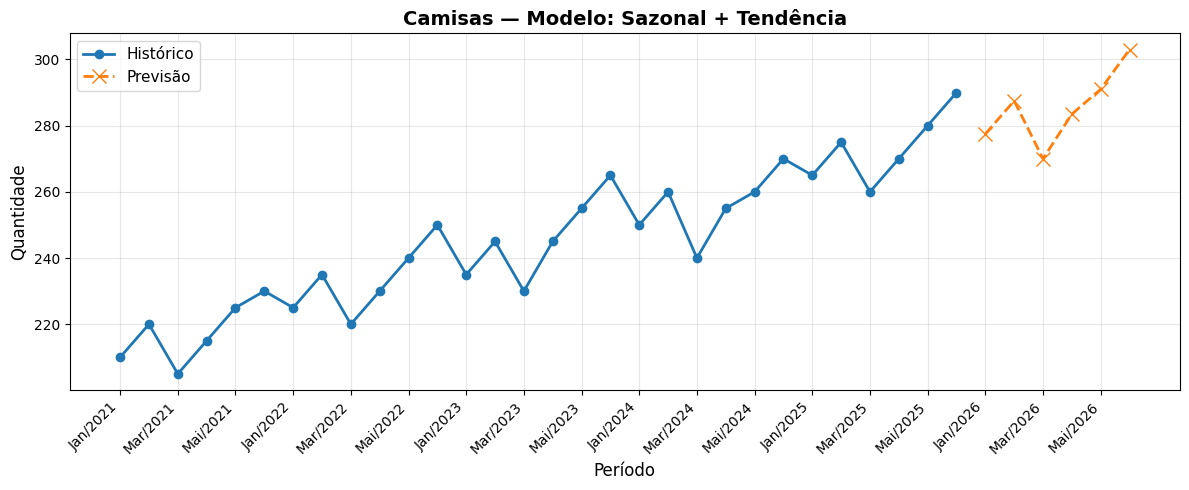

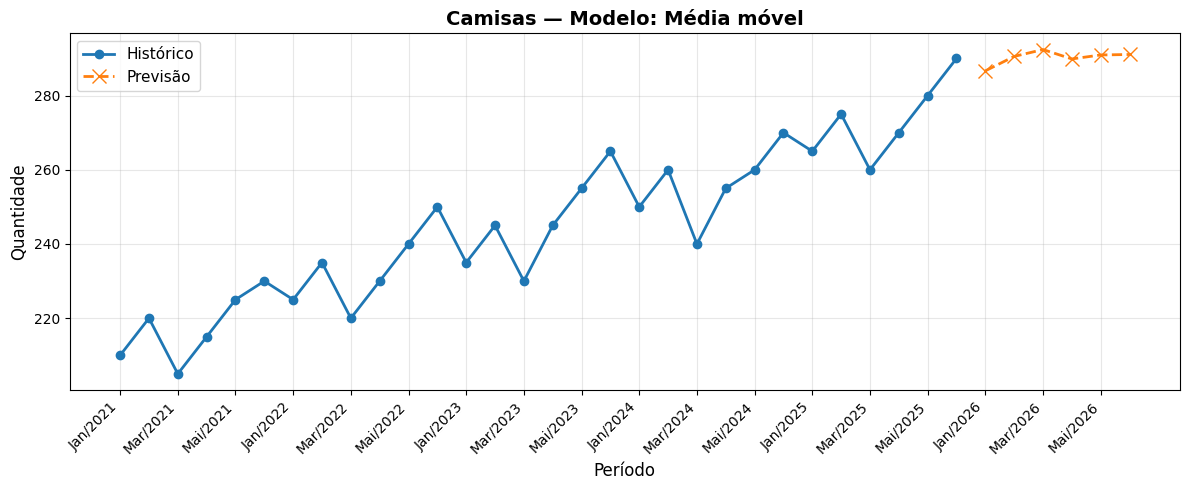

In [54]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
#from models import VendaMensal

connect_db()

warnings.filterwarnings('ignore')


MESES_NOMES = {
    1: "Jan", 2: "Fev", 3: "Mar", 4: "Abr",
    5: "Mai", 6: "Jun", 7: "Jul", 8: "Ago",
    9: "Set", 10: "Out", 11: "Nov", 12: "Dez"
}

class PrevisaoVendasMongo:
    """
    Previsão de vendas baseada no formato:
    { mes, ano, produtos:{Camisas, Calcas, ...} }
    """

    def __init__(self, documentos, produto):
        self.documentos = documentos
        self.produto = produto
        self._preparar_dados()

    def _preparar_dados(self):
        """Transforma {ano, mes} → índice contínuo para treino"""

        ordenados = sorted(self.documentos, key=lambda x: (x['ano'], x['mes']))

        self.X = []
        self.y = []
        self.anos_meses = []  # Guarda pares (ano, mes) reais

        primeiro_ano = ordenados[0]['ano']

        for doc in ordenados:
            indice = (doc['ano'] - primeiro_ano) * 12 + doc['mes']
            self.X.append(indice)
            self.y.append(doc["produtos"].get(self.produto, None))
            self.anos_meses.append((doc['ano'], doc['mes']))

        self.X = np.array(self.X).reshape(-1, 1)
        self.y = np.array(self.y)

        self.ultimo_indice = int(self.X[-1][0])
        self.ultimo_ano = ordenados[-1]['ano']
        self.ultimo_mes = ordenados[-1]['mes']
        self.primeiro_ano = primeiro_ano

    # ================= MODELAGEM =================

    def prever_linear(self, meses_futuros=3):
        modelo = LinearRegression()
        modelo.fit(self.X, self.y)

        X_future = np.array([
            self.ultimo_indice + i for i in range(1, meses_futuros + 1)
        ]).reshape(-1, 1)

        y_pred = modelo.predict(X_future)

        mae = mean_absolute_error(self.y, modelo.predict(self.X))
        r2 = r2_score(self.y, modelo.predict(self.X))

        return {
            "modelo": "Linear",
            "meses": X_future.flatten(),
            "previsoes": y_pred,
            "mae": mae,
            "r2": r2
        }

    def prever_polinomial(self, meses_futuros=3, grau=2):
        poly = PolynomialFeatures(degree=grau)
        X_poly = poly.fit_transform(self.X)

        modelo = LinearRegression()
        modelo.fit(X_poly, self.y)

        X_future = np.array([
            self.ultimo_indice + i for i in range(1, meses_futuros + 1)
        ]).reshape(-1, 1)

        y_pred = modelo.predict(poly.transform(X_future))

        mae = mean_absolute_error(self.y, modelo.predict(X_poly))
        r2 = r2_score(self.y, modelo.predict(X_poly))

        return {
            "modelo": f"Polinomial {grau}",
            "meses": X_future.flatten(),
            "previsoes": y_pred,
            "mae": mae,
            "r2": r2
        }

    def prever_media_movel(self, meses_futuros=3, janela=3):
        dados = list(self.y)
        previsoes = []

        for _ in range(meses_futuros):
            media = np.mean(dados[-janela:])
            previsoes.append(media)
            dados.append(media)

        X_future = np.array([
            self.ultimo_indice + i for i in range(1, meses_futuros + 1)
        ])

        return {
            "modelo": f"Média móvel {janela}",
            "meses": X_future,
            "previsoes": np.array(previsoes),
            "mae": None,
            "r2": None
        }

    def prever_sazonal(self, meses_futuros=3, anos_historico=5):
        """
        Previsão sazonal considerando apenas os últimos N anos do mesmo mês.
        Por exemplo, para prever Janeiro 2025, usa apenas os Janeiros de 2020-2024.
        """
        previsoes = []
        meses_futuros_indices = []

        print(f"\n--- Calculando previsões sazonais ---")

        for i in range(1, meses_futuros + 1):
            indice_futuro = self.ultimo_indice + i

            # Calcula qual mês e ano real será
            mes_futuro = ((self.ultimo_mes + i - 1) % 12) + 1
            ano_futuro = self.ultimo_ano + ((self.ultimo_mes + i - 1) // 12)

            meses_futuros_indices.append(indice_futuro)

            # Busca apenas os dados deste mês específico nos últimos N anos
            valores_mes = []
            anos_usados = []

            for doc in self.documentos:
                if doc["mes"] == mes_futuro:
                    valor = doc["produtos"].get(self.produto, None)
                    if valor is not None:
                        valores_mes.append({'ano': doc['ano'], 'valor': valor})

            # Ordena por ano decrescente e pega os últimos N anos
            valores_mes_ordenados = sorted(valores_mes, key=lambda x: x['ano'], reverse=True)
            ultimos_anos = valores_mes_ordenados[:anos_historico]

            if ultimos_anos:
                valores = [r['valor'] for r in ultimos_anos]
                anos_usados = [r['ano'] for r in ultimos_anos]
                pred = np.mean(valores)

                print(f"\n{MESES_NOMES[mes_futuro]}/{ano_futuro}:")
                print(f"  Anos considerados: {anos_usados}")
                print(f"  Valores: {valores}")
                print(f"  Média: {pred:.2f}")
            else:
                # Se não houver dados para este mês, usa a média geral
                pred = np.mean(self.y)
                print(f"\n{MESES_NOMES[mes_futuro]}/{ano_futuro}: Sem dados históricos, usando média geral = {pred:.2f}")

            previsoes.append(pred)

        return {
            "modelo": f"Sazonal ({anos_historico} anos)",
            "meses": np.array(meses_futuros_indices),
            "previsoes": np.array(previsoes),
        }

    def prever_sazonal_com_tendencia(self, meses_futuros=3, anos_historico=5):
        """
        Previsão sazonal com tendência linear aplicada aos últimos N anos do mesmo mês.
        Identifica se há crescimento/decrescimento ao longo dos anos para aquele mês específico.
        """
        # Organiza os dados por mês específico
        dados_por_mes = {}
        for doc in self.documentos:
            mes = doc["mes"]
            ano = doc["ano"]
            valor = doc["produtos"].get(self.produto, None)

            if valor is not None:
                if mes not in dados_por_mes:
                    dados_por_mes[mes] = []
                dados_por_mes[mes].append({'ano': ano, 'valor': valor})

        previsoes = []
        meses_futuros_indices = []

        for i in range(1, meses_futuros + 1):
            indice_futuro = self.ultimo_indice + i

            # Calcula qual mês e ano real será
            mes_futuro = ((self.ultimo_mes + i - 1) % 12) + 1
            ano_futuro = self.ultimo_ano + ((self.ultimo_mes + i - 1) // 12)

            meses_futuros_indices.append(indice_futuro)

            # Pega os dados históricos deste mês específico
            if mes_futuro in dados_por_mes:
                registros = sorted(dados_por_mes[mes_futuro], key=lambda x: x['ano'], reverse=True)
                ultimos_anos = registros[:anos_historico]

                if len(ultimos_anos) >= 2:
                    # Treina modelo linear com os dados históricos deste mês
                    X_mes = np.array([r['ano'] for r in ultimos_anos]).reshape(-1, 1)
                    y_mes = np.array([r['valor'] for r in ultimos_anos])

                    modelo = LinearRegression()
                    modelo.fit(X_mes, y_mes)

                    # Prevê para o ano futuro
                    pred = modelo.predict([[ano_futuro]])[0]
                else:
                    # Se não houver dados suficientes, usa a média
                    pred = np.mean([r['valor'] for r in ultimos_anos])
            else:
                # Se não houver dados para este mês, usa a média geral
                pred = np.mean(self.y)

            previsoes.append(pred)
            print(f"Previsão (com tendência) para {MESES_NOMES[mes_futuro]}/{ano_futuro}: {pred:.2f}")

        return {
            "modelo": f"Sazonal + Tendência ({anos_historico} anos)",
            "meses": np.array(meses_futuros_indices),
            "previsoes": np.array(previsoes),
        }

    # ================= GRÁFICOS =================

    def plotar_resultados(self, resultados):
        """
        Plota apenas os dados dos meses que estão sendo previstos.
        Por exemplo, se prevê Jan/Fev/Mar, mostra apenas histórico de Jan/Fev/Mar.
        """
        for nome, res in resultados.items():
            plt.figure(figsize=(12, 5))

            # Identifica quais meses estão sendo previstos
            meses_previstos = []
            for idx in res["meses"]:
                mes_num = ((int(idx) - 1) % 12) + 1
                if mes_num not in meses_previstos:
                    meses_previstos.append(mes_num)

            # Filtra o histórico apenas para os meses que estão sendo previstos
            historico_filtrado = []
            labels_filtradas = []

            for i, (ano, mes) in enumerate(self.anos_meses):
                # Só inclui se o mês estiver na lista de meses previstos
                if mes in meses_previstos:
                    historico_filtrado.append(self.y[i])
                    labels_filtradas.append(f"{MESES_NOMES[mes]}/{ano}")

            # Labels das previsões
            previsao_labels = []
            for idx in res["meses"]:
                mes_num = ((int(idx) - 1) % 12) + 1
                ano = self.primeiro_ano + (int(idx) - 1) // 12
                previsao_labels.append(f"{MESES_NOMES[mes_num]}/{ano}")

            # Plota usando posições sequenciais
            x_historico = np.arange(len(historico_filtrado))
            x_previsao = np.arange(len(historico_filtrado), len(historico_filtrado) + len(res["previsoes"]))

            plt.plot(x_historico, historico_filtrado, marker="o", label="Histórico", linewidth=2)
            plt.plot(x_previsao, res["previsoes"], marker="x", linestyle="--",
                    label="Previsão", linewidth=2, markersize=10)

            # Define os labels do eixo X
            todos_labels = labels_filtradas + previsao_labels
            todas_posicoes = list(x_historico) + list(x_previsao)

            # Mostra apenas alguns labels para não ficar muito poluído
            step = max(1, len(todos_labels) // 15)
            plt.xticks(
                todas_posicoes[::step],
                todos_labels[::step],
                rotation=45,
                ha='right'
            )

            plt.title(f"{self.produto} — Modelo: {nome}", fontsize=14, fontweight='bold')
            plt.xlabel("Período", fontsize=12)
            plt.ylabel("Quantidade", fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=11)
            plt.tight_layout()

            plt.show()

    # ================= RELATÓRIO =================

    def relatorio(self, meses_futuros=3, anos_historico=5):
        print(f"\n=== PREVISÃO PARA: {self.produto.upper()} ===")
        print(f"Usando histórico de {anos_historico} anos para sazonalidade\n")

        modelos = {
            "Linear": self.prever_linear(meses_futuros),
            "Polinomial 2": self.prever_polinomial(meses_futuros, grau=2),
            "Sazonal": self.prever_sazonal(meses_futuros, anos_historico),
            "Sazonal + Tendência": self.prever_sazonal_com_tendencia(meses_futuros, anos_historico),
            "Média móvel": self.prever_media_movel(meses_futuros),
        }

        print("\n=== RESUMO DAS PREVISÕES ===")
        for nome, res in modelos.items():
            print(f"\n--- {nome} ---")
            for mes, prev in zip(res["meses"], res["previsoes"]):
                mes_real = ((mes - 1) % 12) + 1
                print(f"{MESES_NOMES[mes_real]}: {int(prev)}")

        # Exibe gráficos
        self.plotar_resultados(modelos)

        return modelos

documentos_mongo = list(VendaMensal.objects().as_pymongo())

# Previsão para Camisas - usando últimos 5 anos para sazonalidade
previsao = PrevisaoVendasMongo(documentos_mongo, "Camisas")
resultados = previsao.relatorio(meses_futuros=6, anos_historico=5)